In [3]:
%pip install pandas numpy tensorflow scikit-learn matplotlib seaborn joblib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 

df = pd.read_csv("modifiedDataset_WithDIM.csv")
visualization_classes = {
    1: "Histogram",
    2: "Pie Chart",
    3: "Map",
    4: "Treemap",
    5: "Parallel Coordinates",
    6: "Scatter Plot",
    7: "Linked Graph",
    8: "Line Chart"
}
expertise_mapping = {
    0: "Non-Expert",
    1: "Expert"
}

df["Target Audience"] = df["Target Audience"].map(expertise_mapping)
df["Chart_Type"] = df["Chart_Type"].map(visualization_classes)

print(df["Chart_Type"].value_counts(normalize=True))

numerical_cols = ["No_of_Attributes", "No_of_Records"]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df = pd.get_dummies(df, columns=['Data_Dimensions','Primary_Variable (Data Type)', 'Task (Purpose)', 'Target Audience'], drop_first=True, dtype=int)

encoded_target = pd.get_dummies(df["Chart_Type"], dtype=int)
df = df.drop(columns=["Chart_Type"])
X = df
Y = encoded_target

print("Mean values:", scaler.mean_)
print("Standard deviation values:", scaler.scale_)

2025-03-09 01:02:13.880490: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 01:02:13.882300: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 01:02:13.887104: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 01:02:13.896705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741482133.913832    1333 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741482133.91

Chart_Type
Histogram               0.2625
Treemap                 0.2025
Parallel Coordinates    0.1400
Pie Chart               0.1375
Map                     0.0725
Line Chart              0.0650
Linked Graph            0.0625
Scatter Plot            0.0575
Name: proportion, dtype: float64
Mean values: [  7.295  498.4625]
Standard deviation values: [ 14.8200194  974.81305315]


In [5]:
df

,No_of_Attributes,No_of_Records,Data_Dimensions_2D,Data_Dimensions_Hierarchical,Data_Dimensions_ND,Primary_Variable (Data Type)_continous,Primary_Variable (Data Type)_geographical,Primary_Variable (Data Type)_ordinal,Task (Purpose)_distribution,Task (Purpose)_relationship,Task (Purpose)_trends,Target Audience_Non-Expert
0,-0.424763,-0.490825,0,0,0,1,0,0,1,0,0,1
1,0.857286,-0.306174,0,0,1,0,0,0,0,1,0,0
2,-0.424763,-0.470308,0,0,0,0,0,1,0,0,1,1
3,-0.424763,-0.506212,0,0,0,1,0,0,1,0,0,1
4,-0.424763,-0.505187,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
395,2.881575,-0.203590,0,0,1,1,0,0,0,1,0,0
396,0.857286,2.053253,0,1,0,0,0,1,0,0,0,0
397,-0.424763,-0.475437,0,0,0,0,0,1,1,0,0,1
398,-0.424763,-0.465179,0,0,0,1,0,0,1,0,0,1


In [6]:
preprocessing_pipeline = {
    "scaler": scaler,
    "feature_columns": X.columns.tolist(),
    "one_hot_columns": list(X.columns)  # Save structure for one-hot encoding
}
pipeline_path = "/workspaces/codespaces-models/visiobot-project/visiobot-backend/saved_models/preprocessing_pipeline.pkl"
joblib.dump(preprocessing_pipeline, pipeline_path)
print(f"Preprocessing pipeline saved successfully at {pipeline_path}")

Preprocessing pipeline saved successfully at /workspaces/codespaces-models/visiobot-project/visiobot-backend/saved_models/preprocessing_pipeline.pkl


In [7]:
print("Scaler mean at inference:", preprocessing_pipeline['scaler'].mean_)
print("Scaler std at inference:", preprocessing_pipeline['scaler'].scale_)

Scaler mean at inference: [  7.295  498.4625]
Scaler std at inference: [ 14.8200194  974.81305315]


Epoch 1/500


2025-03-09 01:02:20.653192: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2768 - loss: 1.9686 - mse: 0.1042 - val_accuracy: 0.4250 - val_loss: 1.5147 - val_mse: 0.0826
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5157 - loss: 1.4116 - mse: 0.0787 - val_accuracy: 0.8250 - val_loss: 0.9172 - val_mse: 0.0530
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8315 - loss: 0.8040 - mse: 0.0466 - val_accuracy: 0.9000 - val_loss: 0.5073 - val_mse: 0.0289
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8708 - loss: 0.5104 - mse: 0.0291 - val_accuracy: 0.9750 - val_loss: 0.2989 - val_mse: 0.0161
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9539 - loss: 0.2648 - mse: 0.0135 - val_accuracy: 0.9750 - val_loss: 0.1955 - val_mse: 0.0106
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9375 - loss: 0.2274 - mse: 0.0125 - val_accuracy: 0.9750 - val_loss: 0.1459 - val_mse: 0.0082
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

PermutationExplainer explainer: 41it [00:10,  2.08s/it]                        
/tmp/ipykernel_1333/2944391874.py:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


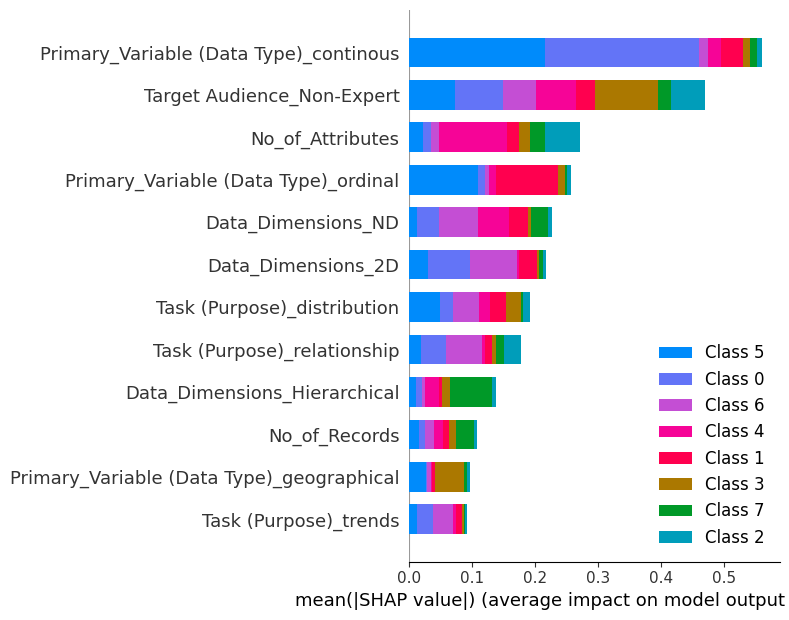

AttributeError: 'PermutationExplainer' object has no attribute 'expected_value'

In [8]:
import os
import shap  # SHAP for Explainability

kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
r2_scores = []
conf_matrix = np.zeros((Y.shape[1], Y.shape[1]))  # Initialize confusion matrix

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    model = Sequential([
        Input(shape=(X_train.shape[1],)), 
        Dense(16, activation='relu'), 
        Dense(12, activation='relu'),  
        Dense(Y.shape[1], activation='softmax') 
    ])
    optimizer = Adam(learning_rate=0.005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', 'mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, Y_train, epochs=500, batch_size=10, verbose=1, validation_data=(X_test, Y_test), callbacks=[early_stopping])
    loss, accuracy, mse = model.evaluate(X_test, Y_test)
    accuracies.append(accuracy)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(Y_test.values, axis=1)
    fold_conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, labels=range(Y.shape[1]))
    conf_matrix += fold_conf_matrix

    r2 = r2_score(y_true_classes, y_pred_classes)
    r2_scores.append(r2)

save_dir = "/workspaces/codespaces-models/visiobot-project/visiobot-backend/saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "visiobot_model.keras")
model.save(model_path)
print("Model saved successfully!")

final_accuracy = np.mean(accuracies) * 100
final_r2 = np.mean(r2_scores)
print(f"Final Mean Accuracy: {final_accuracy:.2f}%")
print(f"Final Mean R² Score: {final_r2:.4f}")

# SHAP Explainability
print("Generating SHAP explanations...")
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

# Force Plot (for a single prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0])

In [7]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │           104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,550 (6.06 KB)

 Trainable params: 516 (2.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,034 (4.04 KB)

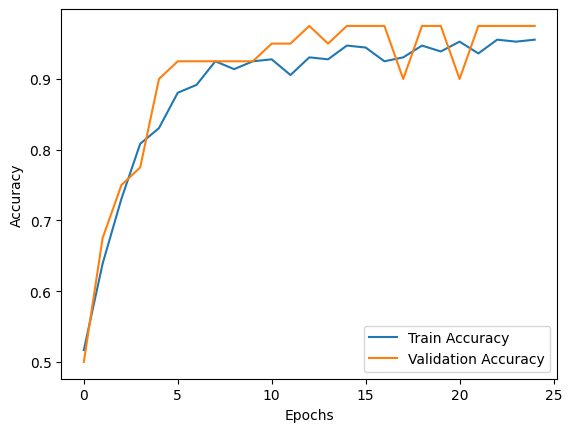

In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

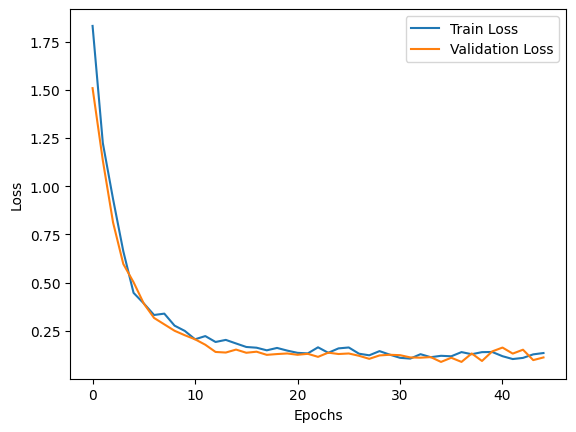

In [15]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

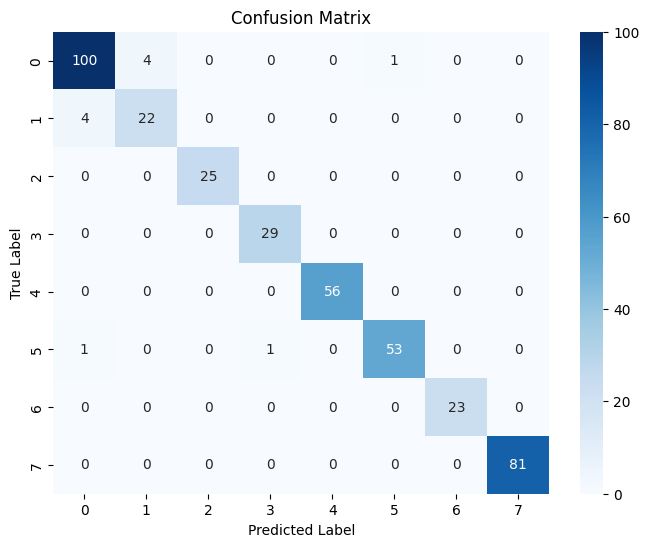

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix.astype(int), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
report = classification_report(y_true_classes, y_pred_classes, target_names=list(visualization_classes.values()), labels=range(8))
print("Classification Report:\n", report)

Classification Report:
                       precision    recall  f1-score   support

           Histogram       1.00      1.00      1.00        11
           Pie Chart       1.00      1.00      1.00         4
                 Map       0.00      0.00      0.00         0
             Treemap       1.00      1.00      1.00         3
Parallel Coordinates       1.00      1.00      1.00         5
        Scatter Plot       1.00      0.88      0.93         8
        Linked Graph       0.86      1.00      0.92         6
          Line Chart       1.00      1.00      1.00         3

            accuracy                           0.97        40
           macro avg       0.86      0.86      0.86        40
        weighted avg       0.98      0.97      0.98        40



/usr/local/python/current/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/python/current/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/python/current/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/

In [18]:
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

TPR = np.sum(TP) / (np.sum(TP) + np.sum(FN))  # Sensitivity / Recall
TNR = np.sum(TN) / (np.sum(TN) + np.sum(FP))  # Specificity
FPR = np.sum(FP) / (np.sum(FP) + np.sum(TN))  # False Positive Rate
FNR = np.sum(FN) / (np.sum(FN) + np.sum(TP))  # False Negative Rate
Precision = np.sum(TP) / (np.sum(TP) + np.sum(FP))  # Precision Calculation
F1 = 2 * (Precision * TPR) / (Precision + TPR)  # F1 Score Calculation

print(f"True Positive Rate (TPR / Sensitivity): {TPR:.4f}")
print(f"True Negative Rate (TNR / Specificity): {TNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"F1 Score: {F1:.4f}")

True Positive Rate (TPR / Sensitivity): 0.9675
True Negative Rate (TNR / Specificity): 0.9954
False Positive Rate (FPR): 0.0046
False Negative Rate (FNR): 0.0325
Precision: 0.9675
F1 Score: 0.9675


In [19]:
try:
    from ucimlrepo import fetch_ucirepo  
except ImportError:
    import os
    os.system("pip install ucimlrepo")
    from ucimlrepo import fetch_ucirepo  

import pandas as pd
abalone = fetch_ucirepo(id=1)  
X = abalone.data.features  
y = abalone.data.targets  
dataset = pd.concat([X, y], axis=1)
csv_filename = "abalone_dataset.csv"
dataset.to_csv(csv_filename, index=False)
print(f"Dataset downloaded and saved as {csv_filename}")

Dataset downloaded and saved as abalone_dataset.csv


In [20]:
try:
    from ucimlrepo import fetch_ucirepo  
except ImportError:
    import os
    os.system("pip install ucimlrepo")
    from ucimlrepo import fetch_ucirepo  

import pandas as pd
mushroom = fetch_ucirepo(id=73)  
X = mushroom.data.features  
y = mushroom.data.targets  
dataset = pd.concat([X, y], axis=1)
csv_filename = "mushroom_dataset.csv"
dataset.to_csv(csv_filename, index=False)

In [21]:

# Check Feature Variance
print("\n🔎 Checking Feature Variance...")
feature_variance = df.var()
print(feature_variance)

# Identify Features with Low Variance
low_variance_features = feature_variance[feature_variance < 0.0001]
print("\n⚠️ Low Variance Features:\n", low_variance_features)


🔎 Checking Feature Variance...
No_of_Attributes                             1.002506
No_of_Records                                1.002506
Data_Dimensions_2D                           0.111523
Data_Dimensions_Hierarchical                 0.167763
Data_Dimensions_ND                           0.131303
Primary_Variable (Data Type)_continous       0.238496
Primary_Variable (Data Type)_geographical    0.080044
Primary_Variable (Data Type)_ordinal         0.192882
Task (Purpose)_distribution                  0.250000
Task (Purpose)_relationship                  0.129568
Task (Purpose)_trends                        0.118891
Target Audience_Non-Expert                   0.250119
dtype: float64

⚠️ Low Variance Features:
 Series([], dtype: float64)
